In [1]:
from sqlalchemy import create_engine
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import numpy as np
import datetime
from urllib.parse import quote_plus

In [2]:
csv_file = 'HINDALCO.csv'
data = pd.read_csv(csv_file)

In [3]:
data['open'] = data['open'].astype(float)  
data['high'] = data['high'].astype(float)  
data['low'] = data['low'].astype(float)    
data['close'] = data['close'].astype(float)  
data['volume'] = data['volume'].astype(int)  
data['instrument'] = data['instrument'].astype(str)
data['datetime'] = pd.to_datetime(data['datetime'])

In [4]:
print(data.dtypes)
print(data.head())

datetime      datetime64[ns]
close                float64
high                 float64
low                  float64
open                 float64
volume                 int64
instrument            object
dtype: object
    datetime   close    high     low    open   volume instrument
0 2014-01-24  114.00  115.35  113.00  113.15  5737135   HINDALCO
1 2014-01-27  111.10  112.70  109.30  112.00  8724577   HINDALCO
2 2014-01-28  113.80  115.00  109.75  110.00  4513345   HINDALCO
3 2014-01-29  111.75  114.75  111.15  114.50  4713458   HINDALCO
4 2014-01-30  108.10  110.70  107.60  110.20  5077231   HINDALCO


In [12]:
import mysql.connector
db_connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Ilm@betu1",
    database="STOCK_PRICE"
)
cursor = db_connection.cursor()
sql_query = """
    INSERT INTO DATA (datetime,close,high,low,open,volume,instrument)
    VALUES (%s, %s, %s, %s, %s, %s, %s)
"""
for index, row in data.iterrows():
    values = (row['datetime'],row['close'], row['high'],row['low'], row['open']  , row['volume'],row['instrument'])
    cursor.execute(sql_query, values)

db_connection.commit()

cursor.close()
db_connection.close()

print("Data inserted successfully.")

Data inserted successfully.


In [13]:
engine = create_engine('mysql+mysqlconnector://root:%s@localhost/STOCK_PRICE' %quote_plus("Ilm@betu1"))
query = "SELECT * FROM DATA"
start_balance = 10000
df = pd.read_sql(query,engine)
df.head()

,id,datetime,close,high,low,open,volume,instrument
0,1,2014-01-24,114.00,115.35,113.00,113.15,5737135,HINDALCO
1,2,2014-01-27,111.10,112.70,109.30,112.00,8724577,HINDALCO
2,3,2014-01-28,113.80,115.00,109.75,110.00,4513345,HINDALCO
3,4,2014-01-29,111.75,114.75,111.15,114.50,4713458,HINDALCO
4,5,2014-01-30,108.10,110.70,107.60,110.20,5077231,HINDALCO


In [14]:
df['return'] = (df['close'] / df['close'].shift(1))
df['return'].iat[0] = 1
df['bench_bal'] = start_balance * df['return'].cumprod()
df.head()

,id,datetime,close,high,low,open,volume,instrument,return,bench_bal
0,1,2014-01-24,114.00,115.35,113.00,113.15,5737135,HINDALCO,1.000000,10000.000000
1,2,2014-01-27,111.10,112.70,109.30,112.00,8724577,HINDALCO,0.974561,9745.614035
2,3,2014-01-28,113.80,115.00,109.75,110.00,4513345,HINDALCO,1.024302,9982.456140
3,4,2014-01-29,111.75,114.75,111.15,114.50,4713458,HINDALCO,0.981986,9802.631579
4,5,2014-01-30,108.10,110.70,107.60,110.20,5077231,HINDALCO,0.967338,9482.456140


In [15]:
df.isnull().sum()

id            0
datetime      0
close         0
high          0
low           0
open          0
volume        0
instrument    0
return        0
bench_bal     0
dtype: int64

In [80]:
bench_return = round(((df['bench_bal'].iloc[-1] / df['bench_bal'].iloc[0])-1)*100,2)
bench_cagr = round((((df['bench_bal'].iloc[-1] / df['bench_bal'].iloc[0]) ** (1/4))-1)*100,2)
print(bench_return)
print(bench_cagr)

96.05
18.33


In [124]:
df['Fast_MA'] = df.close.rolling(window = 25).mean()
df['Slow_MA'] = df.close.rolling(window = 200).mean()
df.tail()

,id,datetime,close,high,low,open,volume,instrument,return,bench_bal,Fast_MA,Slow_MA,Long,Sys_Ret,Sys_Bal
1210,1211,2018-12-21,224.00,227.45,221.80,224.25,6933691,HINDALCO,1.000447,19649.122807,223.166,228.35025,False,1.0,21058.737706
1211,1212,2018-12-24,217.85,224.00,216.95,224.00,4667022,HINDALCO,0.972545,19109.649123,222.682,228.23550,False,1.0,21058.737706
1212,1213,2018-12-26,218.60,219.80,212.90,213.85,6554865,HINDALCO,1.003443,19175.438596,222.048,228.18050,False,1.0,21058.737706
1213,1214,2018-12-27,220.60,223.90,219.60,221.40,7947144,HINDALCO,1.009149,19350.877193,221.994,228.15425,False,1.0,21058.737706
1214,1215,2018-12-28,223.50,226.05,221.00,221.00,5074920,HINDALCO,1.013146,19605.263158,222.008,228.14950,False,1.0,21058.737706


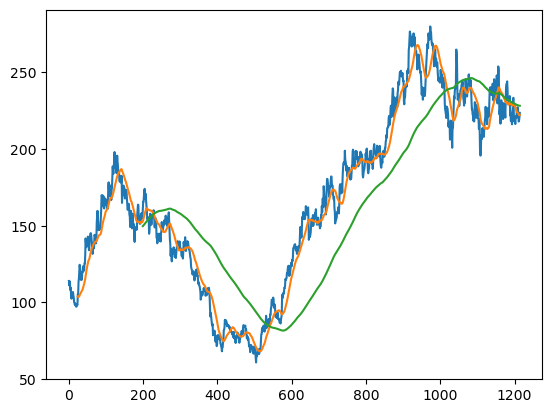

In [125]:
plt.plot(df.close)
plt.plot(df.Fast_MA)
plt.plot(df.Slow_MA)
plt.show()

In [126]:
df['Long'] = df.Fast_MA > df.Slow_MA
df.tail()

,id,datetime,close,high,low,open,volume,instrument,return,bench_bal,Fast_MA,Slow_MA,Long,Sys_Ret,Sys_Bal
1210,1211,2018-12-21,224.00,227.45,221.80,224.25,6933691,HINDALCO,1.000447,19649.122807,223.166,228.35025,False,1.0,21058.737706
1211,1212,2018-12-24,217.85,224.00,216.95,224.00,4667022,HINDALCO,0.972545,19109.649123,222.682,228.23550,False,1.0,21058.737706
1212,1213,2018-12-26,218.60,219.80,212.90,213.85,6554865,HINDALCO,1.003443,19175.438596,222.048,228.18050,False,1.0,21058.737706
1213,1214,2018-12-27,220.60,223.90,219.60,221.40,7947144,HINDALCO,1.009149,19350.877193,221.994,228.15425,False,1.0,21058.737706
1214,1215,2018-12-28,223.50,226.05,221.00,221.00,5074920,HINDALCO,1.013146,19605.263158,222.008,228.14950,False,1.0,21058.737706


In [127]:
df['Sys_Ret'] = np.where(df.Long.shift(1) == True, df['return'], 1)
df.tail()

,id,datetime,close,high,low,open,volume,instrument,return,bench_bal,Fast_MA,Slow_MA,Long,Sys_Ret,Sys_Bal
1210,1211,2018-12-21,224.00,227.45,221.80,224.25,6933691,HINDALCO,1.000447,19649.122807,223.166,228.35025,False,1.0,21058.737706
1211,1212,2018-12-24,217.85,224.00,216.95,224.00,4667022,HINDALCO,0.972545,19109.649123,222.682,228.23550,False,1.0,21058.737706
1212,1213,2018-12-26,218.60,219.80,212.90,213.85,6554865,HINDALCO,1.003443,19175.438596,222.048,228.18050,False,1.0,21058.737706
1213,1214,2018-12-27,220.60,223.90,219.60,221.40,7947144,HINDALCO,1.009149,19350.877193,221.994,228.15425,False,1.0,21058.737706
1214,1215,2018-12-28,223.50,226.05,221.00,221.00,5074920,HINDALCO,1.013146,19605.263158,222.008,228.14950,False,1.0,21058.737706


In [128]:
df['Sys_Bal'] = start_balance * df['Sys_Ret'].cumprod()
df.tail()

,id,datetime,close,high,low,open,volume,instrument,return,bench_bal,Fast_MA,Slow_MA,Long,Sys_Ret,Sys_Bal
1210,1211,2018-12-21,224.00,227.45,221.80,224.25,6933691,HINDALCO,1.000447,19649.122807,223.166,228.35025,False,1.0,23260.618488
1211,1212,2018-12-24,217.85,224.00,216.95,224.00,4667022,HINDALCO,0.972545,19109.649123,222.682,228.23550,False,1.0,23260.618488
1212,1213,2018-12-26,218.60,219.80,212.90,213.85,6554865,HINDALCO,1.003443,19175.438596,222.048,228.18050,False,1.0,23260.618488
1213,1214,2018-12-27,220.60,223.90,219.60,221.40,7947144,HINDALCO,1.009149,19350.877193,221.994,228.15425,False,1.0,23260.618488
1214,1215,2018-12-28,223.50,226.05,221.00,221.00,5074920,HINDALCO,1.013146,19605.263158,222.008,228.14950,False,1.0,23260.618488


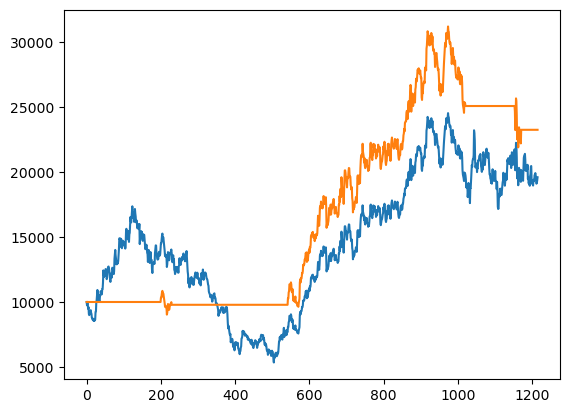

In [129]:
plt.plot(df.bench_bal)
plt.plot(df.Sys_Bal)

plt.show()

In [130]:
sys_return = round(((df.Sys_Bal.iloc[-1] / df.Sys_Bal.iloc[0]) - 1) * 100, 2)
sys_cagr =round((((df.Sys_Bal.iloc[-1] / df.Sys_Bal.iloc[0]) ** (1/4))-1) * 100 , 2)


print(sys_return)
print(sys_cagr)

132.61
23.5


In [133]:
df['bench_peak'] = df.bench_bal.cummax()

df['bench_DD'] = df.bench_bal - df.bench_peak

bench_dd = round((((df.bench_DD / df.bench_peak).min()) * 100), 2)

bench_dd

-69.24

In [134]:
df['Sys_Peak'] = df.Sys_Bal.cummax()

df['Sys_DD'] = df.Sys_Bal - df.Sys_Peak

sys_dd = round((((df.Sys_DD / df.Sys_Peak).min()) * 100), 2)

sys_dd

-29.82

In [135]:
print(f'Benchmark return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_return}%')
print(f'System CAGR: {sys_cagr}')
print(f'System DD: {sys_dd}%')

Benchmark return: 96.05%
Benchmark CAGR: 18.33
Benchmark DD: -69.24%

System Total return: 132.61%
System CAGR: 23.5
System DD: -29.82%
